In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import yaml  # conda install pyyaml
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples
from helper_dataset import get_dataloaders_FashionMnist

In [2]:
# Uncomment the following line to use GPU if exist.
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Uncomment the following line to use CPU
# DEVICE = torch.device("cpu")
print(torch.cuda.is_available())

True


In [62]:
setting_file=  Path('settings.yaml') #os.path.join(PATH,'settings.yaml' )
print (setting_file)

settings.yaml


In [63]:
with open(setting_file) as file:
    SETTINGS = yaml.load(file, Loader=yaml.FullLoader)

In [64]:
# Add the required tranformers, explained in the assignment text
training_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(32,32)),
    torchvision.transforms.RandomCrop(size=(28,28)),
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.RandomHorizontalFlip(1.0),
    torchvision.transforms.Normalize(0.5, 0.5)
])

testing_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize([32,32]),
    torchvision.transforms.CenterCrop([28,28]),
    torchvision.transforms.Normalize(0.5, 0.5)
])
validating_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize([32,32]),
    torchvision.transforms.CenterCrop([28,28]),
    torchvision.transforms.Normalize(0.5, 0.5)
])

In [65]:
# Generate loaders: replace the ???? with appropriate transformers
train_loader, valid_loader, test_loader = get_dataloaders_FashionMnist( batch_size=SETTINGS['batch size'], 
                                            validation_fraction=0.1,
                                            train_transforms=training_transforms,
                                            test_transforms=testing_transforms,
                                            valid_tranforms=validating_transforms
                                            )

In [66]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [67]:
b = next(iter(train_loader))
b[0].size()

torch.Size([128, 1, 28, 28])

In [68]:
len(train_loader)

421

In [69]:
# Replace ???? to define a SubTrain_set as a part of the training dataset using FashionMINST() with 
SubTrain = torchvision.datasets.FashionMNIST(root="data",
                                             train=True,
                                             transform=torchvision.transforms.ToTensor())
# Load the SubTrain_set dataset with batch size equals to 10 
loader_example = torch.utils.data.DataLoader(SubTrain, batch_size=10)

batch = next(iter(loader_example))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

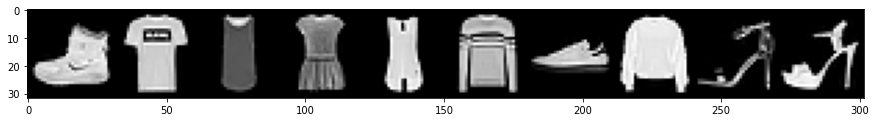

In [70]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [71]:
# ## MODEL
##########################

class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden, num_hidden2, num_classes):
        super().__init__()

        self.num_classes = num_classes

        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, num_hidden, bias=False),  # Hidden Layer
            torch.nn.ReLU(),               # use rectified linear activation function
            torch.nn.Dropout(0.5),               #use dropout 0.5
            # Add 2nd hidden layer with 50 layer and update the setting.yaml accordingly with dropout 0.3
            torch.nn.Linear(num_hidden, num_hidden2, bias=False),
            torch.nn.ReLU(),               # use rectified linear activation function
            torch.nn.Dropout(0.3),       #use dropout 0.5
            torch.nn.Linear(num_hidden2, num_classes)  # Output layer
        )

    def forward(self, x):
        return self.classifier(x)


In [72]:
print(SETTINGS['learning rate'])

0.001


In [73]:
model = MLP(num_features=SETTINGS['input size'],
            num_hidden=SETTINGS['hidden layer size'],
            num_hidden2=SETTINGS['hidden layer size2'],
            num_classes=SETTINGS['num class labels'])
model.to(DEVICE)

MLP(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=False)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=False)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [74]:
optimizer = torch.optim.SGD(model.parameters(), lr=SETTINGS['learning rate']) # get the learning rate from the settings.yaml

In [75]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [76]:
# Replace ???? with suitable parameter defined in settings.yaml and suitable parameters defined in the above cells
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=SETTINGS['num epochs'],
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=800,
    scheduler=scheduler,
    scheduler_on='valid_acc')



Epoch: 001/050 | Batch 0000/0421 | Loss: 2.3068
Epoch: 001/050 | Train: 24.25% | Validation: 21.53%
Time elapsed: 1.13 min
Epoch: 002/050 | Batch 0000/0421 | Loss: 2.2495
Epoch: 002/050 | Train: 31.06% | Validation: 26.58%
Time elapsed: 2.26 min
Epoch: 003/050 | Batch 0000/0421 | Loss: 2.1744
Epoch: 003/050 | Train: 38.37% | Validation: 35.07%
Time elapsed: 3.38 min
Epoch: 004/050 | Batch 0000/0421 | Loss: 2.1052
Epoch: 004/050 | Train: 40.50% | Validation: 34.57%
Time elapsed: 4.51 min
Epoch: 005/050 | Batch 0000/0421 | Loss: 2.0091
Epoch: 005/050 | Train: 41.73% | Validation: 34.75%
Time elapsed: 5.62 min
Epoch: 006/050 | Batch 0000/0421 | Loss: 1.9530
Epoch: 006/050 | Train: 44.04% | Validation: 37.07%
Time elapsed: 6.73 min
Epoch: 007/050 | Batch 0000/0421 | Loss: 1.8070
Epoch: 007/050 | Train: 47.26% | Validation: 41.07%
Time elapsed: 7.84 min
Epoch: 008/050 | Batch 0000/0421 | Loss: 1.7206
Epoch: 008/050 | Train: 49.91% | Validation: 43.85%
Time elapsed: 8.92 min
Epoch: 009/050 |

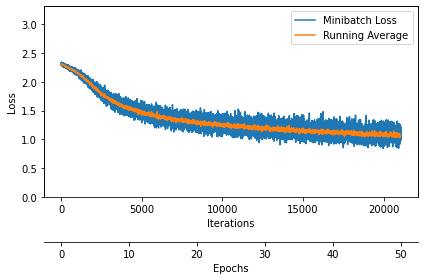

In [77]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=SETTINGS['num epochs'],
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

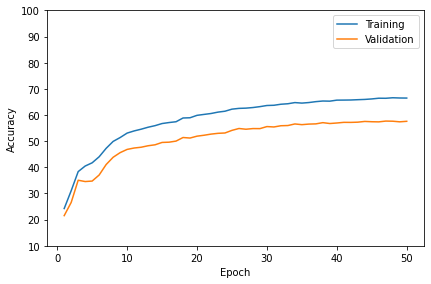

In [80]:
plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([10, 100])
plt.show()